In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# GitHub API authentication (use your personal access token)
GITHUB_TOKEN = "fill your token here"
headers = {'Authorization': f'token {GITHUB_TOKEN}'}

### Method to pull the list of user login in Berlin who has more than 200 followers

In [ ]:
def get_berlin_users():
    users = []
    page = 1
    per_page = 50  # GitHub allows fetching 100 results per page

    while True:
        # Search users in Berlin with more than 200 followers
        url = f"https://api.github.com/search/users?q=location:Berlin+followers:>200&per_page={per_page}&page={page}"
        response = requests.get(url, headers=headers)
        data = response.json()

        # Exit if no more users are found
        if 'items' not in data or len(data['items']) == 0:
            break

        users.extend(data['items'])
        page += 1
        # Pause to avoid rate-limiting
        time.sleep(1)

    return users

### Method to fetch the user details for the given user login id

In [ ]:
def get_user_details(user_login):
    # Fetch user details
    user_url = f"https://api.github.com/users/{user_login}"
    user_response = requests.get(user_url, headers=headers)
    user_data = user_response.json()

    return user_data

### Method to fetch the repositories upto 500 per page for the given user login id

In [ ]:
def get_user_repositories_details(user_login):
    # Fetch user repositories
    repos_url = f"https://api.github.com/users/{user_login}/repos?sort=pushed&per_page=500"
    repos_response = requests.get(repos_url, headers=headers)
    repos_data = repos_response.json()

    # return user_data, repos_data
    return repos_data

### Method to clean the company name as per the given instruction

In [ ]:
def clean_company_name(company):
    if company:
        company = company.strip()  # Remove leading/trailing whitespace
        company = company.lstrip('@')  # Remove leading '@'
        company = company.strip()  # Remove leading/trailing whitespace
        company = company.upper()  # Convert to uppercase
    return company

### Method to iterate over the list of user login's passed. For each user fetch the details and populate the users list

In [ ]:
def scrape_berlin_users_to_csv(users):
    user_list = []
    for user_login in users:
        user_data = get_user_details(user_login)
        user_info = {
            'login': user_data.get('login'),
            'name': user_data.get('name'),
            'company': clean_company_name(user_data.get('company')),
            'location': user_data.get('location'),
            'email': user_data.get('email'),
            'hireable': 'true' if user_data.get('hireable') else 'false',
            'bio': user_data.get('bio'),
            'public_repos': user_data.get('public_repos'),
            'followers': user_data.get('followers'),
            'following': user_data.get('following'),
            'created_at': user_data.get('created_at')
        }
        user_list.append(user_info)

        time.sleep(1)

    # Create DataFrame and save to CSV
    df_users = pd.DataFrame(user_list)
    df_users.to_csv('users.csv', encoding='utf-8', index=False)
    print("Data saved to users.csv")

### Method to fetch the all the repositories for each users in the users list. Iterate over the repositories for each user and populate the repositories list

In [ ]:
def scrape_berlin_users_repositories_to_csv(users):
    user_repo_data = []
    for user_login in users:

        # Get detailed user info and repos
        # user_data, repos_data = get_user_details(user_login)

        repo_data = get_user_repositories_details(user_login)

        for repo in repo_data:
          repo_info = {
              'login': user_login,
              'full_name': repo.get('full_name'),
              'created_at': repo.get('created_at'),
              'stargazers_count': repo.get('stargazers_count'),
              'watchers_count': repo.get('watchers_count'),
              'language': repo.get('language'),
              'has_projects': 'true' if repo.get('has_projects') else 'false',
              'has_wiki': 'true' if repo.get('has_wiki') else 'false',
              'license_name' : repo.get('license', {}).get('key') if repo.get('license') else None
          }
          user_repo_data.append(repo_info)
    # Create DataFrame and save to CSV
    df_users_repo = pd.DataFrame(user_repo_data)
    df_users_repo.to_csv('repositories.csv', encoding='utf-8', index=False)
    print("Data saved to repositories.csv")

In [ ]:
berlin_users = get_berlin_users()
users = [user['login'] for user in berlin_users]

In [ ]:
scrape_berlin_users_to_csv(users)

Data saved to users.csv


In [ ]:
scrape_berlin_users_repositories_to_csv(users)

Data saved to repositories.csv


### Execute the next step if the users and repositories data was already scraped and kept in drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_users = pd.read_csv('/content/drive/My Drive/users.csv')
df_repositories = pd.read_csv('/content/drive/My Drive/repositories.csv')

Mounted at /content/drive


### Execute this step if users and repositories data was scraped now

In [ ]:
df_users = pd.read_csv('users.csv')
df_repositories = pd.read_csv('repositories.csv')

### Question 1

In [ ]:
top5followers = df_users.sort_values(by=['followers'],ascending=False)['login'][0:5]
",".join(list(top5followers))

'tiangolo,schacon,rwieruch,shuding,android10'

### Question 2

In [ ]:
early5creators = df_users.sort_values(by=['created_at'],ascending=True)['login'][0:5]
",".join(list(early5creators))

'schacon,adamwiggins,myobie,lstoll,znarf'

### Question 3

In [ ]:
','.join(df_repositories['license_name'].value_counts().head(3).index)

'mit,apache-2.0,other'

### Question 4

In [ ]:
','.join(df_users['company'].value_counts().head(1).index)

'MICROSOFT'

### Question 5

In [ ]:
df_repositories['language'].value_counts().head(1).index[0]

'JavaScript'

### Question 6

In [ ]:
df_repositories[df_repositories['login'].isin(df_users[pd.to_datetime(df_users['created_at']).dt.year > 2020]['login'])]['language'].value_counts().head(2).index[-1]

'JavaScript'

### Question 7

In [ ]:
pivot_table = pd.pivot_table(df_repositories,index='language',values='stargazers_count',aggfunc='mean',sort=True)
sorted_pivot = pivot_table.sort_values(by='stargazers_count', ascending=False)
sorted_pivot.index[0]

'Fluent'

### Question 8

In [ ]:
df_users['leader_strength'] = df_users['followers']/(1+df_users['following'])
",".join(df_users.sort_values(by='leader_strength', ascending=False)['login'].head(5))

'tiangolo,marijnh,vakila,alexeygrigorev,lewagon'

### Question 9

In [ ]:
np.round(df_users['followers'].corr(df_users['public_repos']),3)

0.017

### Question 10

In [ ]:
model = LinearRegression()

In [ ]:
X = df_users[['public_repos']]
y = df_users['followers']
np.round(model.fit(X,y).coef_[0],3)

0.279

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(df_users['public_repos'], df_users['followers'])
np.round(slope,3)

0.279

### Question 11

In [ ]:
np.round(df_repositories['has_projects'].corr(df_repositories['has_wiki']),3)

0.405

### Question 12

In [ ]:
df_users['hireable'] = df_users['hireable'].fillna(False)
np.round((df_users[df_users['hireable']]['following'].mean() - df_users[~df_users['hireable']]['following'].mean()),3)

47.492

### Question 13

In [ ]:
nonempty_bio = df_users[df_users['bio'].notna()]
nonempty_bio['biocount'] = nonempty_bio['bio'].str.strip().str.split().apply(len)

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(nonempty_bio['biocount'], nonempty_bio['followers'])
print(f"Correlation between bio word count and followers: {correlation:.3f}")
print(f"Regression slope of followers on bio word count: {slope:.3f}")

Correlation between bio word count and followers: 0.119
Regression slope of followers on bio word count: 28.501


### Question 14

In [ ]:
df_repositories['created_at'] = pd.to_datetime(df_repositories['created_at'])
df_repositories['is_weekend'] = df_repositories['created_at'].dt.dayofweek.isin([5, 6])
",".join(pd.pivot_table(df_repositories[df_repositories['is_weekend']],values='created_at',index='login',aggfunc='count').rename(columns={'created_at': 'weekend_repo_count'}).sort_values(by='weekend_repo_count', ascending=False).index[0:5])

'janpio,denisdefreyne,MohamedMesto,PurpleBooth,generall'

### Question 15

In [ ]:
hireable_true = df_users[df_users['hireable'] == True]
fraction_hireable_true = hireable_true['email'].notna().mean()

hireable_other = df_users[df_users['hireable'] != True]
fraction_hireable_other = hireable_other['email'].notna().mean()

print(f"{(fraction_hireable_true - fraction_hireable_other):.3f}")

-0.012


### Question 16

In [ ]:
df_users['name'].str.strip().str.split().str[-1].value_counts().index[0]

'Schneider'

### Other Analysis

In [ ]:
df_repositories['language'].value_counts().sum()

30006

In [ ]:
new_df = pd.DataFrame({'year':df_repositories['created_at'].dt.year,'language':df_repositories['language']})
new_df = new_df[new_df['language'].notna()]
new_df

,year,language
0,2019,Python
1,2016,Python
2,2019,Python
3,2019,Python
4,2019,Python
...,...,...
41060,2017,Python
41061,2017,Python
41062,2016,HTML
41064,2016,Nginx


In [ ]:
language_counts = new_df.groupby(['language', 'year']).size().reset_index(name='count')
language_counts

,language,year,count
0,AGS Script,2014,1
1,AMPL,2020,1
2,ASL,2024,1
3,ASP,2016,1
4,ASP,2017,1
...,...,...,...
984,Zig,2019,1
985,Zig,2020,1
986,Zig,2021,3
987,Zig,2023,1


In [ ]:
toplanguages = new_df.groupby(['language']).size().reset_index(name='count').sort_values(by='count',ascending=False)
toplanguages['cumulative_percentage'] = toplanguages['count'].cumsum() / toplanguages['count'].sum() * 100
top_80_languages = toplanguages[toplanguages['cumulative_percentage'] <= 80]
top_80_languages

,language,count,cumulative_percentage
76,JavaScript,6437,21.507568
133,Python,3511,33.238665
61,Go,1885,39.536904
169,TypeScript,1665,45.100070
142,Ruby,1571,50.349160
64,HTML,1506,55.381069
143,Rust,1504,60.406295
75,Java,1416,65.137492
116,PHP,1033,68.588994
152,Shell,1006,71.950282


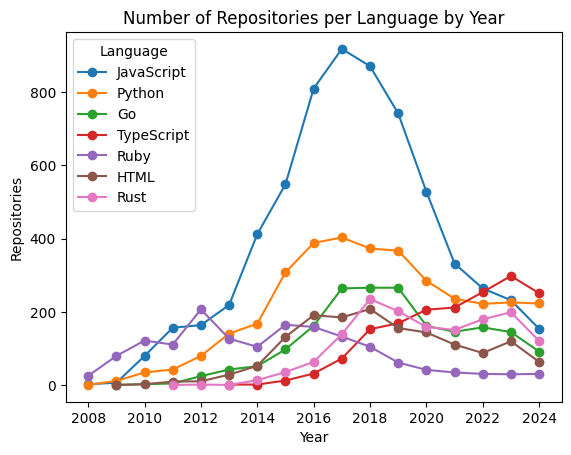

In [ ]:
import matplotlib.pyplot as plt
for i in range(7):
 language = toplanguages['language'].iloc[i]
 x = language_counts[language_counts['language'] == language]['year']
 y = language_counts[language_counts['language'] == language]['count']
 plt.plot(x, y, marker='o', label=language)
 plt.legend(title="Language")

plt.title("Number of Repositories per Language by Year")
plt.xlabel("Year")
plt.ylabel("Repositories")
plt.show()



In [ ]:
top_followers = df_users.sort_values(by=['followers'],ascending=[False])[['login','public_repos','followers']].head(10)
top_followers

,login,public_repos,followers
0,tiangolo,73,26440
1,schacon,215,13756
2,rwieruch,151,8618
3,shuding,149,6755
4,android10,79,6716
5,marijnh,54,6523
6,mxmnk,7,6460
7,nikic,110,6232
8,greenrobot,22,5506
9,sebastianruder,32,5466


In [ ]:
top_repos = df_users.sort_values(by=['public_repos'],ascending=[False])[['login','public_repos','followers']].head(10)
top_repos

,login,public_repos,followers
221,blueyed,595,494
126,derhuerst,582,766
254,ff6347,518,431
180,wolfv,493,584
419,objcio,477,284
428,mr-c,476,280
155,janpio,471,654
166,localheinz,452,618
143,skade,420,708
287,jpkrohling,393,387


In [ ]:
top_languages = list(top_80_languages['language'].values)

In [ ]:
df_top_languages = df_repositories[df_repositories['language'].isin(top_languages)].groupby(['login']).size().reset_index(name='toplanguages')
df_top_languages

,login,toplanguages
0,0mp,28
1,343max,40
2,AbdullahBakir97,42
3,AlaaAttya,66
4,AlexDenisov,35
...,...,...
589,zeenix,64
590,znarf,29
591,zoepage,24
592,zubairehman,1


In [ ]:
df_result = top_followers.merge(df_top_languages, on='login', how='inner')
df_result['toplanguagerepos'] = df_result['toplanguages'] / df_result['public_repos'] * 100

df_result

,login,public_repos,followers,toplanguages,toplanguagerepos
0,tiangolo,73,26440,39,53.424658
1,schacon,215,13756,50,23.255814
2,rwieruch,151,8618,75,49.668874
3,shuding,149,6755,73,48.993289
4,android10,79,6716,37,46.835443
5,marijnh,54,6523,39,72.222222
6,mxmnk,7,6460,5,71.428571
7,nikic,110,6232,52,47.272727
8,greenrobot,22,5506,16,72.727273
9,sebastianruder,32,5466,17,53.125000


In [ ]:
df_result2 = top_repos.merge(df_top_languages, on='login', how='inner')
df_result2['toplanguagerepos'] = df_result2['toplanguages'] / df_result2['public_repos'] * 100

df_result2

,login,public_repos,followers,toplanguages,toplanguagerepos
0,blueyed,595,494,45,7.563025
1,derhuerst,582,766,89,15.292096
2,ff6347,518,431,65,12.548263
3,wolfv,493,584,19,3.853955
4,mr-c,476,280,12,2.521008
5,janpio,471,654,11,2.335456
6,localheinz,452,618,60,13.274336
7,skade,420,708,35,8.333333
8,jpkrohling,393,387,32,8.142494


In [ ]:
stargazers_per_language = df_repositories.groupby('language').agg(total_stargazers=('stargazers_count', 'sum'),repo_count=('stargazers_count', 'size')).reset_index().sort_values(by='total_stargazers', ascending=False).head(12)
stargazers_per_language['average_stargazers'] = np.round((stargazers_per_language['total_stargazers']/stargazers_per_language['repo_count']),2)
stargazers_per_language.sort_values(by=['average_stargazers'],ascending=False).head(12)

,language,total_stargazers,repo_count,average_stargazers
28,Clojure,87015,202,430.77
169,TypeScript,248075,1665,148.99
75,Java,123045,1416,86.90
21,C++,84036,969,86.72
133,Python,265850,3511,75.72
61,Go,142291,1885,75.49
143,Rust,111104,1504,73.87
76,JavaScript,304326,6437,47.28
116,PHP,48560,1033,47.01
152,Shell,47039,1006,46.76


In [ ]:
stargazers_per_language[stargazers_per_language['language'].isin(top_80_languages)]

,language,total_stargazers,repo_count,average_stargazers


In [ ]:
stargazers_per_language['total_stargazers'].corr(stargazers_per_language['repo_count'])

0.912996264788537

In [ ]:
watcher_per_language = df_repositories.groupby('language').agg(total_watchers=('watchers_count', 'sum'),repo_count=('watchers_count', 'size')).reset_index().sort_values(by='total_watchers', ascending=False)
watcher_per_language['average_watchers'] = np.round((watcher_per_language['total_watchers']/watcher_per_language['repo_count']),2)
watcher_per_language.sort_values(by=['average_watchers'],ascending=False).head(12)

,language,total_watchers,repo_count,average_watchers
52,Fluent,12934,1,12934.00
147,Sass,3921,2,1960.50
8,AppleScript,3120,2,1560.00
92,MDX,19592,24,816.33
98,Mercury,457,1,457.00
28,Clojure,87015,202,430.77
170,Typst,251,1,251.00
4,ActionScript,1698,7,242.57
184,XSLT,1383,6,230.50
71,Idris,390,2,195.00


In [ ]:
watcher_per_language['total_watchers'].corr(watcher_per_language['repo_count'])

0.912996264788537